In [1]:
%load_ext autoreload
%autoreload 2

from preprocessing import oversample_minority_classes
import numpy as np; np.random.seed(0)
from config import OUTPUT_DIR
from util import *
from AL import AL_split, mAP_and_APs, evaluation_dict, AL_resnet16_simulation
import pickle

2024-10-02 05:45:51.094072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 05:45:51.094114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 05:45:51.095314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 05:45:51.102148: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 05:45:51.933520: W tensorflow/comp

In [2]:
X = np.load(INTERMEDIATE / 'logmel_multiclass_noise.npy')
Y = np.load(INTERMEDIATE / 'logmel_labels_multiclass_noise.npy')

In [4]:
from AL import AL_split
from models import build_resnet16
import keras_cv
from keras import metrics
from keras.callbacks import EarlyStopping

init, pool, test = AL_split(X, Y)
init_X, init_Y = init
test_X, test_Y = test


model = build_resnet16((40, 107, 1))
model.compile(optimizer='adam',
          loss=keras_cv.losses.FocalLoss(alpha=0.25, gamma=2), 
          metrics=[
            metrics.Recall(thresholds=0.5), # NOTE: useless: macro
            metrics.Precision(thresholds=0.5), # NOTE: useless: macro
            metrics.AUC(curve='pr', name='auc_pr') # NOTE: useless: macro
          ])

earlystopping_cp = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
)

model.fit(init_X, init_Y, 
          validation_data=(test_X, test_Y), 
          epochs=6, verbose=2,
          batch_size=32,
          callbacks=[earlystopping_cp])

Epoch 1/6


2024-10-02 05:48:16.153478: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 724655360 exceeds 10% of free system memory.


1059/1059 - 91s - 86ms/step - auc_pr: 0.9903 - loss: 0.0215 - precision_1: 0.9871 - recall_1: 0.9625 - val_auc_pr: 0.9969 - val_loss: 0.0132 - val_precision_1: 0.9896 - val_recall_1: 0.9839
Epoch 2/6
1059/1059 - 76s - 72ms/step - auc_pr: 0.9977 - loss: 0.0098 - precision_1: 0.9925 - recall_1: 0.9810 - val_auc_pr: 0.9972 - val_loss: 0.0121 - val_precision_1: 0.9892 - val_recall_1: 0.9753
Epoch 3/6
1059/1059 - 82s - 77ms/step - auc_pr: 0.9988 - loss: 0.0073 - precision_1: 0.9943 - recall_1: 0.9830 - val_auc_pr: 0.9975 - val_loss: 0.0102 - val_precision_1: 0.9942 - val_recall_1: 0.9710
Epoch 4/6
1059/1059 - 79s - 74ms/step - auc_pr: 0.9991 - loss: 0.0061 - precision_1: 0.9952 - recall_1: 0.9857 - val_auc_pr: 0.9981 - val_loss: 0.0090 - val_precision_1: 0.9923 - val_recall_1: 0.9847
Epoch 5/6
1059/1059 - 79s - 75ms/step - auc_pr: 0.9994 - loss: 0.0051 - precision_1: 0.9962 - recall_1: 0.9870 - val_auc_pr: 0.9986 - val_loss: 0.0072 - val_precision_1: 0.9941 - val_recall_1: 0.9864
Epoch 6/6


In [5]:
model.save(MODEL_DIR / 'init_trained.keras')

In [6]:
import keras 

model_loaded = keras.saving.load_model(MODEL_DIR / 'init_trained.keras')

2024-10-02 06:03:34.419950: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 724655360 exceeds 10% of free system memory.


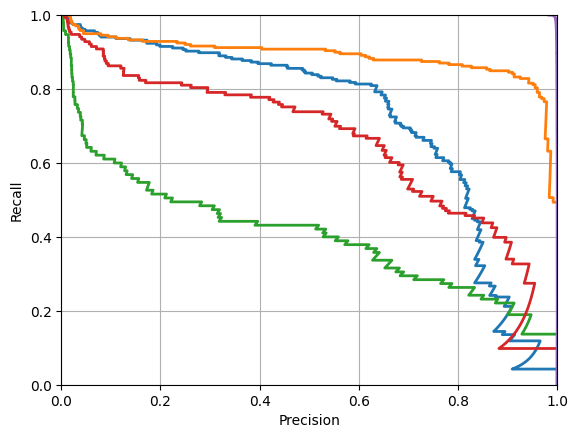

In [11]:
from AL import *

pred = model.predict(test_X, verbose=0)
plot_multiclass_pr_curve(test_Y, pred)

In [20]:

from scikeras.wrappers import KerasClassifier
import keras 


model = keras.saving.load_model(MODEL_DIR / 'init_trained.keras')
classifier = KerasClassifier(model, batch_size=32, verbose=2, random_state=0, warm_start=True)
learner = ActiveLearner(
    estimator=classifier,
    verbose=2,
    
)


In [22]:
classifier.fit(init_X[0:1], init_Y[0:1], epochs=1)

1/1 - 4s - 4s/step - auc_pr: 1.0000 - loss: 1.5663e-05 - precision_1: 1.0000 - recall_1: 1.0000


KerasClassifier(
	model=<Functional name=functional_1, built=True>
	build_fn=None
	warm_start=True
	random_state=0
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [25]:
pred = learner.predict_proba(test_X)

1323/1323 - 19s - 14ms/step


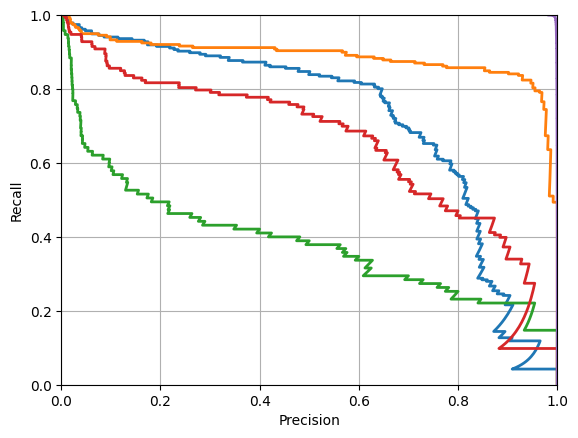

In [26]:
plot_multiclass_pr_curve(test_Y, pred)